Enter your message: POC PROJECT
Original Message: POC PROJECT
HDLC Frame: 01111110000000010000001001010000010011110100001100100000010100000101001001001111010010100100010101000011010101000001100101111110
HDLC Frame Without Flags: 0000000100000010010100000100111101000011001000000101000001010010010011110100101001000101010000110101010000011001
Alice's Key: [1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1]
Bob's Key:   [1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 

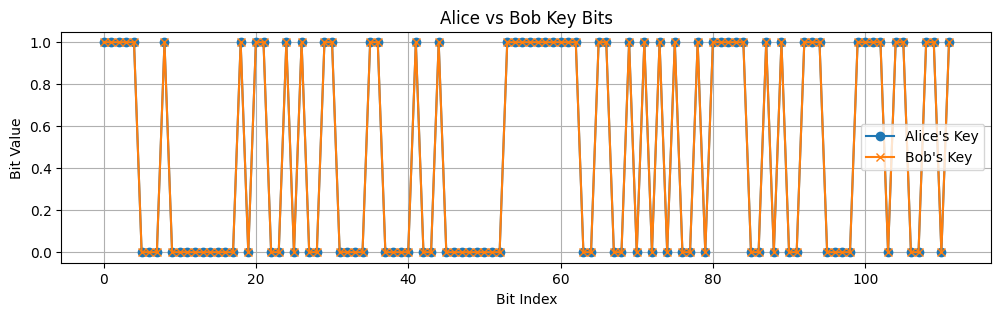

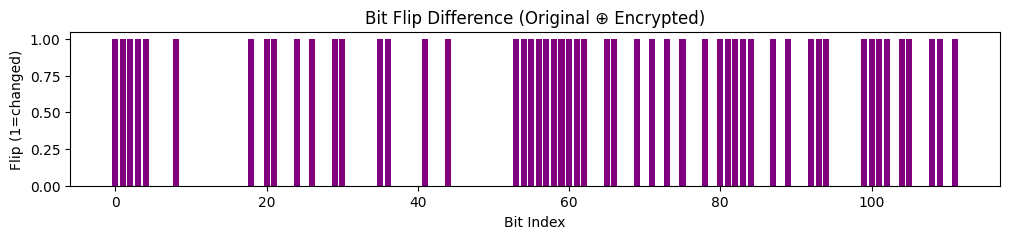

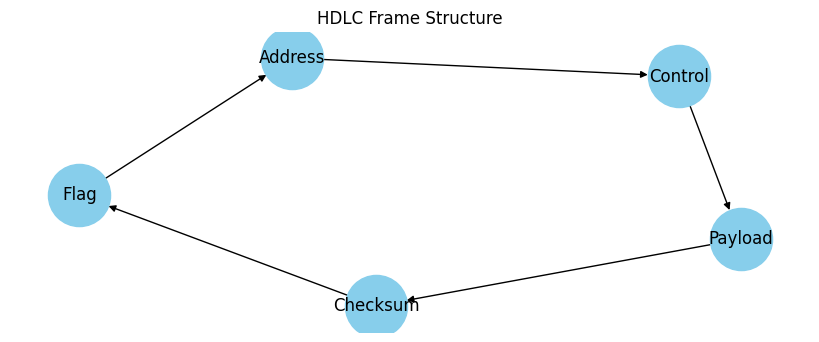

┌───┐     ┌───┐┌─┐   
q_0: ┤ H ├──■──┤ H ├┤M├───
     └───┘┌─┴─┐├───┤└╥┘┌─┐
q_1: ─────┤ X ├┤ H ├─╫─┤M├
          └───┘└───┘ ║ └╥┘
c: 2/════════════════╩══╩═
                     0  1

In [3]:

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import random
import matplotlib.pyplot as plt
import networkx as nx

# -----------------------------
# 1. E91 QKD PROTOCOL
# -----------------------------
def create_entangled_pair():
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    return qc

def e91_measure(qc, alice_basis, bob_basis):
    if alice_basis == 'X':
        qc.h(0)
    if bob_basis == 'X':
        qc.h(1)
    qc.measure(0, 0)
    qc.measure(1, 1)
    return qc

def simulate_e91_key(bits=8):
    backend = AerSimulator()
    alice_key, bob_key = [], []

    for _ in range(bits * 2):  # extra rounds for mismatches
        qc = create_entangled_pair()
        alice_basis = random.choice(['X', 'Z'])
        bob_basis = random.choice(['X', 'Z'])
        qc = e91_measure(qc, alice_basis, bob_basis)
        qc = transpile(qc, backend)
        result = backend.run(qc, shots=1).result()
        measured = list(result.get_counts().keys())[0]
        if alice_basis == bob_basis:
            bob_key.append(int(measured[0]))
            alice_key.append(int(measured[1]))

    key_length = min(len(alice_key), len(bob_key), bits)
    return alice_key[:key_length], bob_key[:key_length]

# -----------------------------
# 2. HDLC FRAME CREATION
# -----------------------------
def create_hdlc_frame(data):
    flag = '01111110'
    address = '00000001'
    control = '00000010'
    payload = ''.join(format(ord(c), '08b') for c in data)
    checksum = format(sum([ord(c) for c in data]) % 256, '08b')
    return flag + address + control + payload + checksum + flag

def parse_hdlc_frame(frame):
    if not frame.startswith('01111110') or not frame.endswith('01111110'):
        print("Frame is corrupted or incorrect!")
        return None
    payload_bin = frame[24:-16]
    if len(payload_bin) % 8 != 0:
        print("Payload length is not a multiple of 8!")
        return None
    return ''.join(chr(int(payload_bin[i:i+8], 2)) for i in range(0, len(payload_bin), 8))

# -----------------------------
# 3. XOR ENCRYPTION
# -----------------------------
def xor_encrypt(binary_data, key_bits):
    data_len, key_len = len(binary_data), len(key_bits)
    if data_len < key_len:
        binary_data = binary_data.ljust(key_len, '0')
    elif data_len > key_len:
        key_bits = key_bits + [0] * (data_len - key_len)
    while len(binary_data) % 8 != 0:
        binary_data += '0'
    return ''.join(str(int(b) ^ k) for b, k in zip(binary_data, key_bits))

# -----------------------------
# 4. RUNNING SIMULATION
# -----------------------------
message = input("Enter your message: ")
print("Original Message:", message)

frame = create_hdlc_frame(message)
print("HDLC Frame:", frame)

frame_without_flags = frame[8:-8]
print("HDLC Frame Without Flags:", frame_without_flags)

alice_key, bob_key = simulate_e91_key(len(frame_without_flags))
print("Alice's Key:", alice_key)
print("Bob's Key:  ", bob_key)

cipher = xor_encrypt(frame_without_flags, alice_key)
print("Encrypted:", cipher)

decrypted = xor_encrypt(cipher, bob_key)
print("Decrypted Frame:", decrypted)

decrypted_with_flags = '01111110' + decrypted + '01111110'
print("Decrypted Frame with Flags:", decrypted_with_flags)

received = parse_hdlc_frame(decrypted_with_flags)
print("Recovered Message:", received)

# -----------------------------
# 5. VISUALIZATIONS
# -----------------------------

# (A) Plot Alice vs Bob Key Bits
plt.figure(figsize=(12, 3))
plt.plot(alice_key, label="Alice's Key", marker='o')
plt.plot(bob_key, label="Bob's Key", marker='x')
plt.title("Alice vs Bob Key Bits")
plt.xlabel("Bit Index")
plt.ylabel("Bit Value")
plt.legend()
plt.grid(True)
plt.show()

# (B) Show XOR difference between original and encrypted data
diff_bits = [int(a) ^ int(b) for a, b in zip(frame_without_flags, cipher)]
plt.figure(figsize=(12, 2))
plt.bar(range(len(diff_bits)), diff_bits, color='purple')
plt.title("Bit Flip Difference (Original ⊕ Encrypted)")
plt.xlabel("Bit Index")
plt.ylabel("Flip (1=changed)")
plt.show()

# (C) HDLC Frame Structure Diagram
G = nx.DiGraph()
G.add_edges_from([
    ("Flag", "Address"),
    ("Address", "Control"),
    ("Control", "Payload"),
    ("Payload", "Checksum"),
    ("Checksum", "Flag"),
])

plt.figure(figsize=(8, 3))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=12, arrows=True)
plt.title("HDLC Frame Structure")
plt.show()

# (D) Display a Quantum Circuit Diagram for E91
circuit_example = e91_measure(create_entangled_pair(), 'X', 'X')
circuit_example.draw('text')


In [2]:
!pip install --upgrade pylatexenc

!pip install qiskit matplotlib networkx
!pip install qiskit
!pip install qiskit qiskit-aer --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=d5a66c3dc29ff1a11e16ce8fcad2ec3b5bbc6829a92afe6c72a1d5da1339574a
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 103.5 MB/s eta 0:00:00
